In [1]:
#!pip install pandas
#!pip install chinese_calendar
#!pip install scikit-learn
#!pip install seaborn
# !pip install matplotlab==3.4.0

In [2]:
import requests
import pandas as pd
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 爬取数据

In [3]:
#找到的链接示例为http://www.cffex.com.cn/sj/hqsj/rtj/202312/26/20231226_1.csv
dir_name='data'
def data_loader(dir_name='data'):
    os.makedirs(dir_name,exist_ok=True)
    base_url='http://www.cffex.com.cn/sj/hqsj/rtj'
    
    #选取爬虫所需要的时间段
    start_date=datetime(2020,1,20)#为什么选定为2020_1_20？因为之前没有IO-C的数据
    end_date=datetime(2023,12,26)
    date=start_date
    #爬去数据
    while date<=end_date:
        url=f"{base_url}/{date.strftime('%Y%m')}/{date.strftime('%d')}/{date.strftime('%Y%m%d')}_1.csv"
        response=requests.get(url)
        #判断是否能返回正常的.csv文件：
        if response.headers['Content-Type']=='text/csv':
            file_path=f"{dir_name}/{date.strftime('%Y%m%d')}_1.csv"
            with open(file_path,'wb') as file:
                file.write(response.content)#写入
            print(f'Downloaded {file_path}')
        date+=timedelta(days=1)
# data_loader()

必要的库，如果已经安装，可以注释掉

# 获取行权日

In [4]:
from pandas.tseries.offsets import WeekOfMonth
from chinese_calendar import is_holiday

#输入起始日期和结束日期，返回期间所有的期权的行权日
def get_strike_day_calender(start_date=datetime(2018,1,1),end_date=datetime(2024,1,26)):
    third_friday=pd.date_range(start=start_date.strftime('%Y%m%d'),end=end_date.strftime('%Y%m%d'),
                           freq=WeekOfMonth(week=2,weekday=4))
    strike_day=[]
    for day in third_friday:
        while is_holiday(day):
            day+=timedelta(days=1)
        strike_day.append(day)
    return strike_day
strike_day_calendar=get_strike_day_calender()

In [5]:
#输入日期，返回对应的行权日
def get_strike_day(date,strike_day_calendar):
    for day in strike_day_calendar:
        if date<=day:
            return day
#get_strike_day(datetime(2021,1,1),strike_day_calendar)

# 数据准备，准备模型的输入和输出
CALL_PRICE模型
Input:
1.IF近月合约的每日结算价(if_stl_price)
2.IO行权价与1的价差(即知道了IO行权价)
3.距离行权日的天数
Output:
1.IO_call近月合约的每日结算价(io_stl_price)

PUT_PRICE模型
Input:
1.IF近月合约的每日结算价(if_stl_price)
2.IO行权价与1的价差(即知道了IO行权价)
3.距离行权日的天数
Output:
1.IO_put近月合约的每日结算价(io_stl_price)

In [6]:
def get_IO_C(dir_name,file_name,strike_day_calendar,CALL=True):
    df=pd.read_csv(dir_name+'/'+file_name,encoding='GBK')
    #获取当天的日期
    date=datetime(int(file_name[:4]),int(file_name[4:6]),int(file_name[6:8]))

    #获取IF近月合约的数据
    strike_day=get_strike_day(date,strike_day_calendar)
    df_IF=df[df['合约代码'].str.startswith('IF'+strike_day.strftime('%y%m'))].copy()

    #获取IO-C对应的数据，包括距离行权日的天数
    if CALL:
        df_IO_C=df[df['合约代码'].str.startswith('IO'+strike_day.strftime('%y%m')+'-C')].copy()
    else:
        df_IO_C=df[df['合约代码'].str.startswith('IO'+strike_day.strftime('%y%m')+'-P')].copy()
    df_IO_C['strike']=df_IO_C['合约代码'].str[9:13].astype('int64')
    df_IO_C['IOIF_delta_price']=df_IO_C['strike']-df_IF['今结算'].values
    df_IO_C['exp_day']=np.full(len(df_IO_C),(strike_day-date)
                               .days)
    df_IO_C['IF_close']=np.full(len(df_IO_C),df_IF['今结算'].values[0])
    df_IO_C['date']=np.full(len(df_IO_C),date)
    #获取所有需要的数据
    data_IO_C=df_IO_C[['date','IF_close','合约代码','strike','IOIF_delta_price','exp_day','今结算']].reset_index(drop=True).copy()
    data_IO_C.rename(columns={'今结算':'IO_close','合约代码':'code'},inplace=True)
    return data_IO_C

In [7]:
#批量处理并合并数据，得到所有的IO_C数据
'''data_IO_C_all=pd.DataFrame()
data_IO_P_all=pd.DataFrame()
for file in os.listdir(dir_name):
    data_IO_C=get_IO_C(dir_name,file,strike_day_calendar)
    data_IO_C_all=pd.concat([data_IO_C_all,data_IO_C],axis=0)
    data_IO_P=get_IO_C(dir_name,file,strike_day_calendar,CALL=False)
    data_IO_P_all=pd.concat([data_IO_P_all,data_IO_P],axis=0)'''

'data_IO_C_all=pd.DataFrame()\ndata_IO_P_all=pd.DataFrame()\nfor file in os.listdir(dir_name):\n    data_IO_C=get_IO_C(dir_name,file,strike_day_calendar)\n    data_IO_C_all=pd.concat([data_IO_C_all,data_IO_C],axis=0)\n    data_IO_P=get_IO_C(dir_name,file,strike_day_calendar,CALL=False)\n    data_IO_P_all=pd.concat([data_IO_P_all,data_IO_P],axis=0)'

In [8]:
#data_IO_P_all.to_csv('data_IO_P_all.csv',index=False)
data_IO_P_all=pd.read_csv('data_IO_P_all.csv')
data_IO_P_all.head()

,date,IF_close,code,strike,IOIF_delta_price,exp_day,IO_close
0,2020-01-20,4194.8,IO2002-P-3550,3550,-644.8,32,0.8
1,2020-01-20,4194.8,IO2002-P-3600,3600,-594.8,32,0.8
2,2020-01-20,4194.8,IO2002-P-3650,3650,-544.8,32,0.8
3,2020-01-20,4194.8,IO2002-P-3700,3700,-494.8,32,1.0
4,2020-01-20,4194.8,IO2002-P-3750,3750,-444.8,32,1.4


In [9]:
# data_IO_C_all.to_csv('data_IO_C_all.csv',index=False)
data_IO_C_all=pd.read_csv('data_IO_C_all.csv')
data_IO_C_all.head()

,date,IF_close,code,strike,IOIF_delta_price,exp_day,IO_close
0,2020-01-20,4194.8,IO2002-C-3550,3550,-644.8,32,643.8
1,2020-01-20,4194.8,IO2002-C-3600,3600,-594.8,32,594.0
2,2020-01-20,4194.8,IO2002-C-3650,3650,-544.8,32,553.2
3,2020-01-20,4194.8,IO2002-C-3700,3700,-494.8,32,506.4
4,2020-01-20,4194.8,IO2002-C-3750,3750,-444.8,32,457.0


# CALL_STL_PRICE模型(梯度提升树拟合)

In [10]:
#划分训练集，验证集，测试集；7:1:2
from sklearn.model_selection import train_test_split
# 不打乱数据，直接划分
train_data,test_data = data_IO_C_all[:int(len(data_IO_C_all)*0.8)],data_IO_C_all[int(len(data_IO_C_all)*0.8):]
train_data,val_data = train_data[:int(len(train_data)*0.875)],train_data[int(len(train_data)*0.875):]
X_train,y_train=train_data[['IF_close','IOIF_delta_price','exp_day']].values,train_data['IO_close'].values
X_val,y_val=val_data[['IF_close','IOIF_delta_price','exp_day']].values,val_data['IO_close'].values
X_test,y_test=test_data[['IF_close','IOIF_delta_price','exp_day']].values,test_data['IO_close'].values
print(y_train)
#用树模型训练梯度提升回归模型
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
model=GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,max_depth=7,random_state=42)
model.fit(X_train,y_train)
y_val_pred=model.predict(X_val)
print('验证集MSE:',mean_squared_error(y_val,y_val_pred))
y_test_pred=model.predict(X_test)
print('测试集MSE:',mean_squared_error(y_test,y_test_pred))
y_train_pred=model.predict(X_train)

[643.8 594.  553.2 ...  28.6  17.   11. ]
验证集MSE: 95.33902287260622
测试集MSE: 369.5468475845762


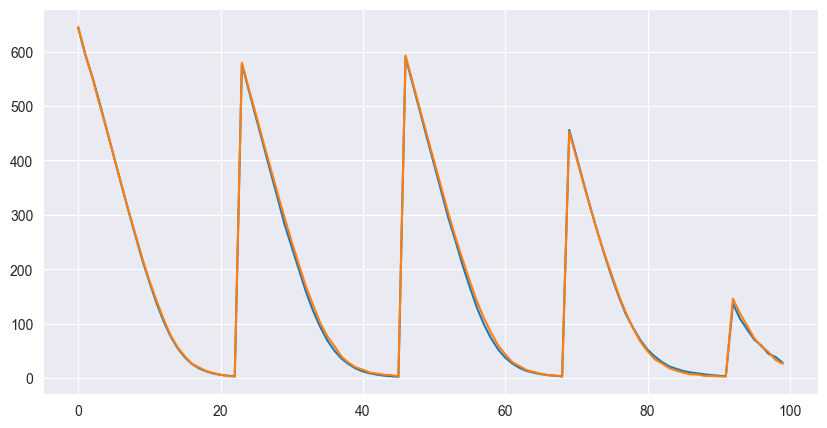

array([643.8, 594. , 553.2, ...,  28.6,  17. ,  11. ])

In [11]:
plt.figure(figsize=(10,5))
plt.plot(y_train[:100],label='true')
plt.plot(y_train_pred[:100],label='pred')
plt.show()
y_train

画出部分test_data的预测值和真实值的对比图,用折线图

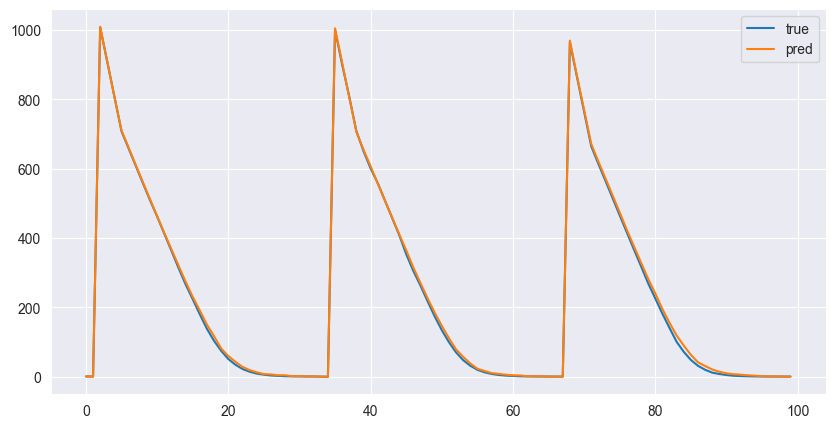

In [12]:
#画出test_data的预测值和真实值的对比图,用折线图
plt.figure(figsize=(10,5))
plt.plot(y_test[:100],label='true')
plt.plot(y_test_pred[:100],label='pred')
plt.legend()
plt.show()

In [13]:
y_test[-100:]

array([ 27.8,  18.6,  11.6,   8.4,   5.2,   3.4,   2.4,   1.8,   1.2,
         1. ,   0.8,   0.8, 403. , 353.2, 304. , 255.6, 208.6, 164.6,
       123. ,  89.6,  61.4,  40.8,  26.2,  16.4,  10.4,   7.2,   4. ,
         2.6,   1.6,   1.4,   1. ,   1. ,   0.8,   0.6, 406.4, 357. ,
       310. , 263. , 213.8, 169. , 125.8,  90. ,  60.2,  40. ,  25. ,
        15.8,   9.4,   6.8,   3.8,   2.6,   1.6,   1.2,   0.8,   0.8,
         0.8,   0.8, 387.2, 337.8, 284.6, 236.8, 195.2, 149.6, 109.4,
        76.4,  50. ,  32. ,  20.2,  12.6,   7.4,   5. ,   2.6,   2. ,
         1.2,   1. ,   0.8,   0.8,   0.8,   0.6, 394. , 344.6, 295.4,
       247.2, 200. , 154.8, 114.6,  80. ,  53.4,  34.4,  21.8,  13. ,
         7.8,   5.4,   2.8,   2. ,   1.4,   1. ,   0.8,   0.8,   0.6,
         0.6])

# PUT_STL_PRICE模型(梯度提升树拟合)

In [14]:
#划分训练集，验证集，测试集；7:1:2
train_data, test_data = data_IO_P_all[:int(len(data_IO_P_all)*0.8)], data_IO_P_all[int(len(data_IO_P_all)*0.8):]
train_data, val_data = train_data[:int(len(train_data)*0.875)], train_data[int(len(train_data)*0.875):]
X_train, y_train = train_data[['IF_close', 'IOIF_delta_price', 'exp_day']].values, train_data['IO_close'].values
X_val, y_val = val_data[['IF_close', 'IOIF_delta_price', 'exp_day']].values, val_data['IO_close'].values
X_test, y_test = test_data[['IF_close', 'IOIF_delta_price', 'exp_day']].values, test_data['IO_close'].values

#用树模型训练梯度提升回归模型
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
print('MSE:', mean_squared_error(y_val, y_val_pred))
y_test_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_test_pred))

MSE: 148.2701762197995
MSE: 485.8020558287972


画出部分test_data的预测值和真实值的对比图,用折线图

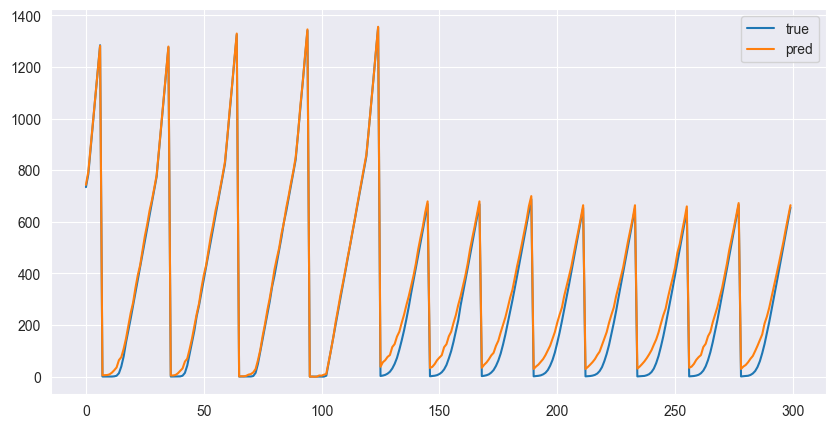

In [26]:
#画出test_data的预测值和真实值的对比图,用折线图
plt.figure(figsize=(10, 5))
plt.plot(y_test[-300:], label='true')
plt.plot(y_test_pred[-300:], label='pred')
plt.legend()
plt.show()

# 绘制近6个月的io_call_stl_price, io_put_stl_price, if_stl_price
其中前两个公用一个y轴；if_stl_price用独立y轴
分别用箱型图和散点图来画图

In [16]:
grouped_data_C=data_IO_C_all.groupby('date')['IO_close'].apply(list)
if_price=data_IO_C_all.groupby('date')['IF_close'].mean().reset_index()
grouped_data_C=grouped_data_C[-140:].reset_index()
if_price=if_price[-140:].reset_index(drop=True)
grouped_data_P=data_IO_P_all.groupby('date')['IO_close'].apply(list)
grouped_data_P=grouped_data_P[-140:].reset_index()

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 绘制近6个月的io_put_stl_price, if_stl_price

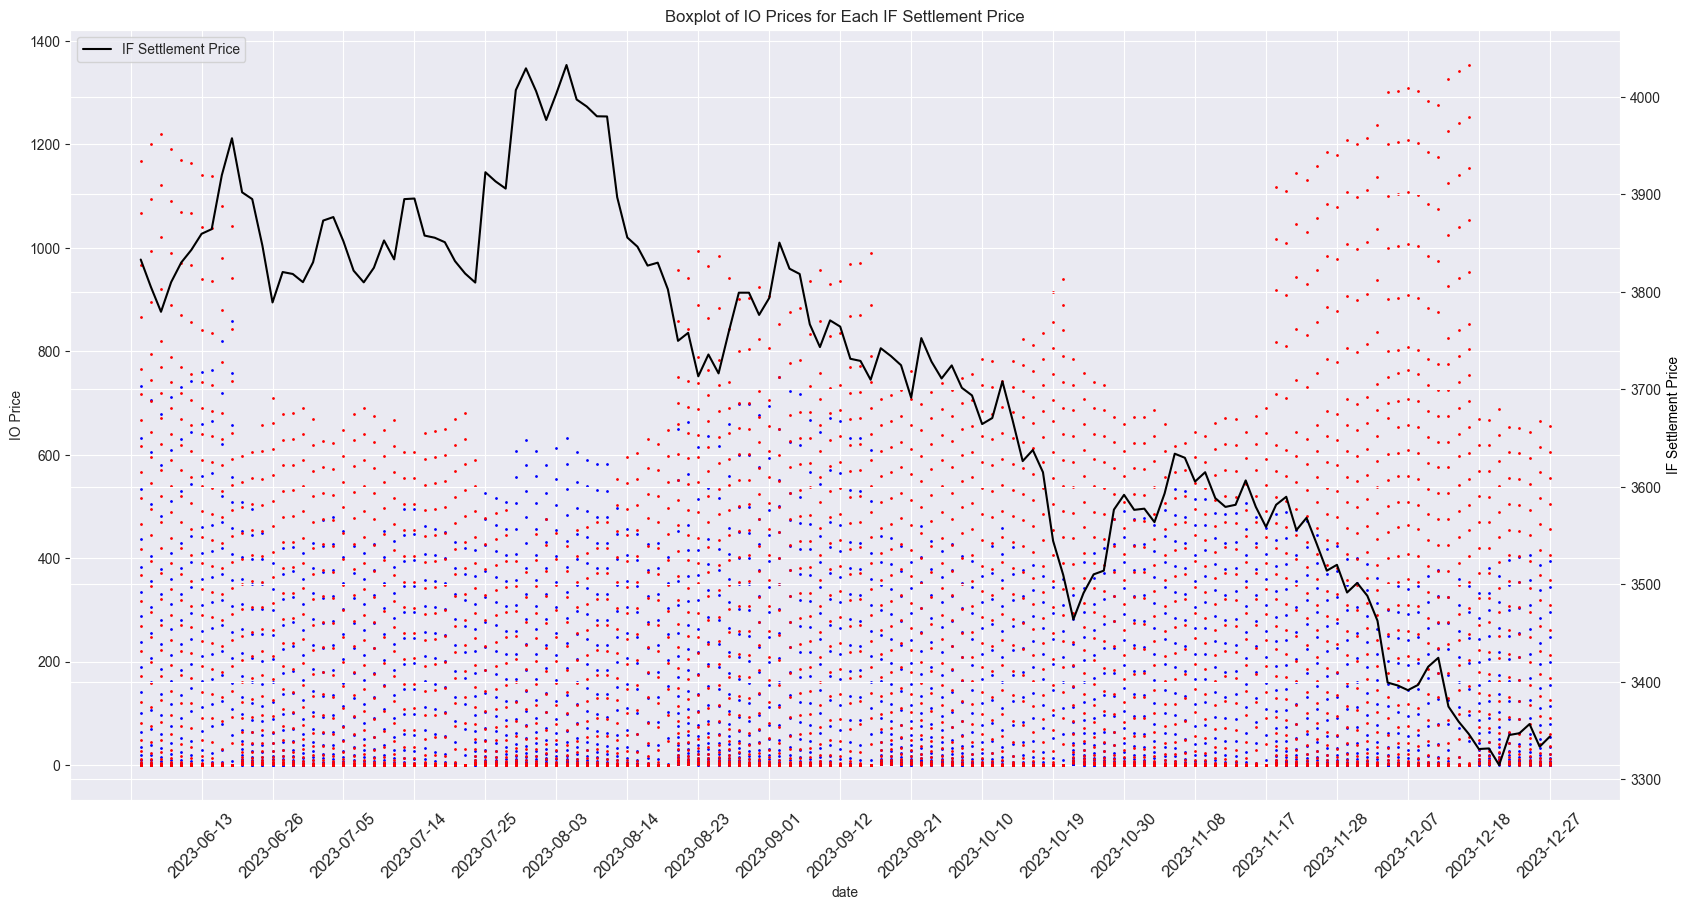

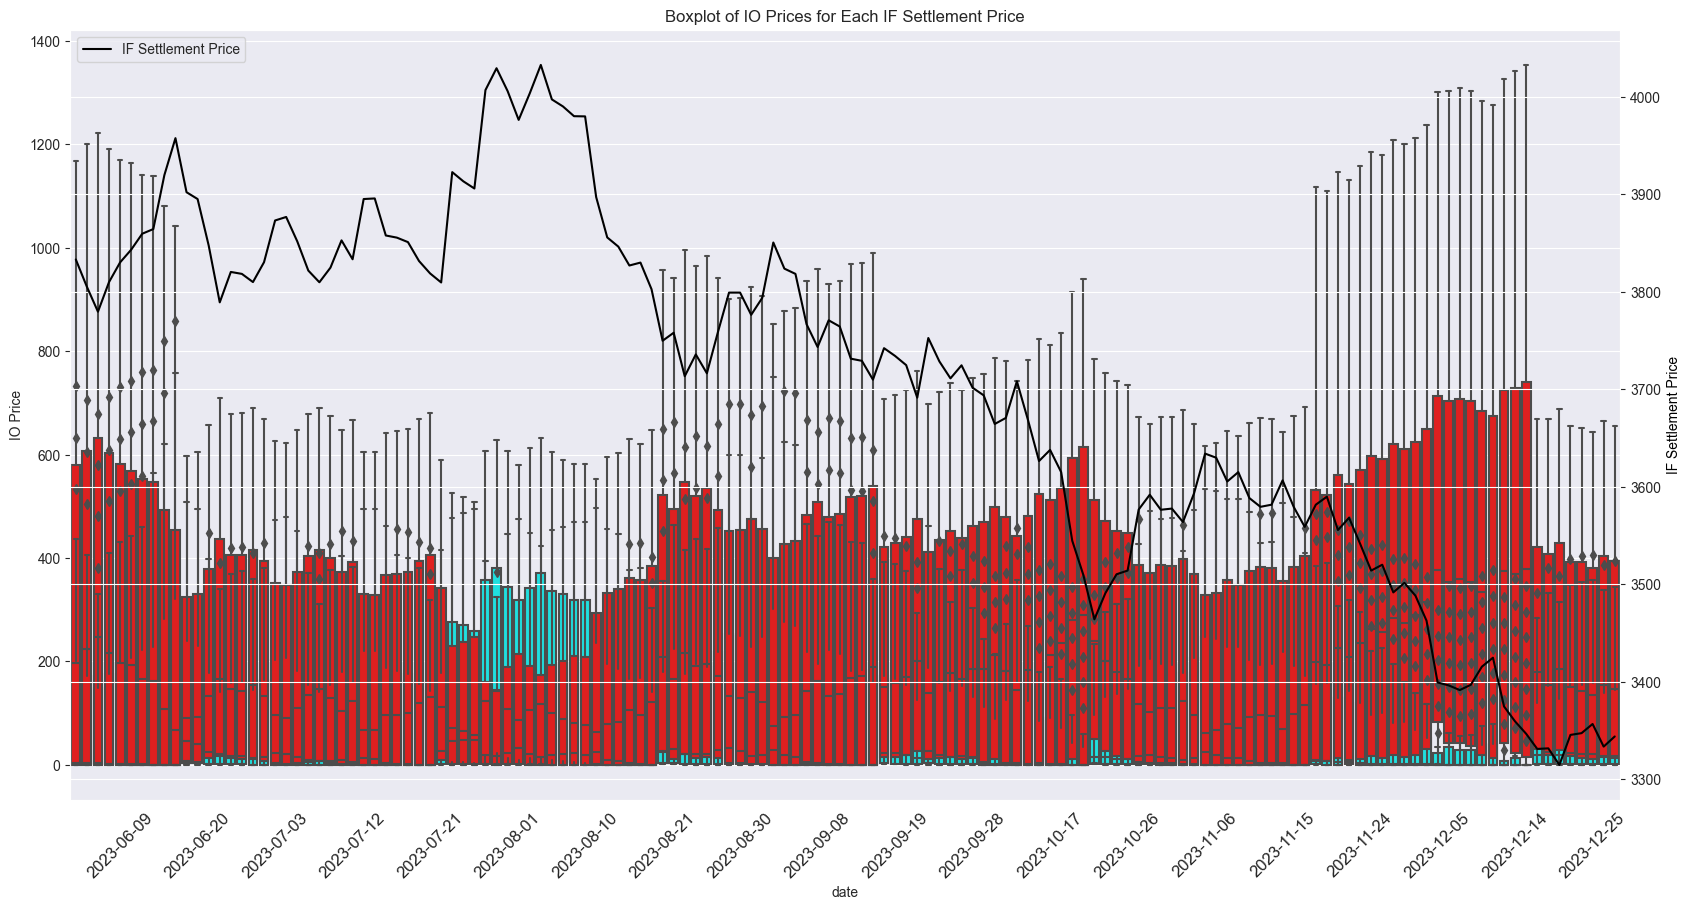

In [18]:
def plt_IO_price(grouped_data_C,grouped_data_P,if_price,SCATTER=True):
    # 转换数据为长格式
    long_format_data_C = []
    for index, row in grouped_data_C.iterrows():
        for price in row['IO_close']:
            long_format_data_C.append({'date': row['date'], 'io_price': price})
    long_format_df_C = pd.DataFrame(long_format_data_C)
    
    long_format_data_P = []
    for index, row in grouped_data_P.iterrows():
        for price in row['IO_close']:
            long_format_data_P.append({'date': row['date'], 'io_price': price})
    long_format_df_P = pd.DataFrame(long_format_data_P)

    # 绘制箱型图
    plt.figure(figsize=(20, 10))
    
    
    # 用散点图来画图
    if SCATTER:
        plt.scatter(x=long_format_df_C['date'], y=long_format_df_C['io_price'], color='blue', s=1)
        plt.scatter(x=long_format_df_P['date'], y=long_format_df_P['io_price'], color='red', s=1)
    else:
        sns.boxplot(x='date', y='io_price', data=long_format_df_C, color='aqua')
        sns.boxplot(x='date', y='io_price', data=long_format_df_P, color='red')

    plt.xlabel('date')
    plt.ylabel('IO Price')
    plt.title('Boxplot of IO Prices for Each IF Settlement Price')
    plt.xticks(rotation=45, fontsize=12)  # 根据需要旋转x轴标签

    # 使用独立的y轴绘制IF的结算价
    ax2 = plt.gca().twinx()
    date_np = np.array(if_price['date'])
    if_np = np.array(if_price['IF_close'])
    ax2.plot(date_np, if_np, color='black', label='IF Settlement Price')
    ax2.set_ylabel('IF Settlement Price', color='black')
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 每7天一个次要刻度
    ax2.legend(loc='upper left')
    plt.show()
    
plt_IO_price(grouped_data_C,grouped_data_P,if_price,SCATTER=True)
plt_IO_price(grouped_data_C,grouped_data_P,if_price,SCATTER=False)

# 用LSTM来拟合CALL_STL_PRICE和PUT_STL_PRICE

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
def LoadData(df):
    features = df[['IF_close', 'IOIF_delta_price', 'exp_day']]
    labels = df['IO_close']

    #数据标准化
    scaler = StandardScaler()
    features = scaler.fit_transform(features)  # 标准化特征

    #划分数据集
    X_train, X_test = features[:int(len(features)*0.8)], features[int(len(features)*0.8):]
    y_train, y_test = labels[:int(len(labels)*0.8)], labels[int(len(labels)*0.8):]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
    
    #转换为PyTorch张量
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val.values, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    X_train = X_train.unsqueeze(1)  # 将形状从 [batch_size, number_of_features] 调整为 [batch_size, 1, number_of_features]
    X_val = X_val.unsqueeze(1)
    X_test = X_test.unsqueeze(1)

    #DataLoader
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    Batch_size = 64
    
    train_loader = DataLoader(train_data, batch_size=Batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=Batch_size)
    test_loader = DataLoader(test_data, batch_size=Batch_size)
    return train_loader,val_loader,test_loader

In [20]:
import torch.nn as nn

# 定义LSTM模型
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)      
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        device = x.device
        # 初始化
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)    

        out, _ = self.lstm(x, (h0, c0))   
        out = out[:, -1, :]# 取LSTM输出的最后一个时间步
        out = self.fc(out)
        return out

#模型参数
input_size = 3  # 由于有三个特征
hidden_size = 64  # 隐藏层大小
num_layers = 2  # LSTM层数
model = LSTMRegressor(input_size, hidden_size, num_layers=num_layers)
print(model)

LSTMRegressor(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [21]:
#定义参数的CLASS
class Args():
    def __init__(self):
        self.lr=0.01
        self.num_epochs=150
        self.best_val_loss=float('inf')
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using {self.device}')
        self.criterion=nn.MSELoss()
        self.optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
        #self.scheduler=ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-6, verbose=True)

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def LSTM_train(model, train_loader, val_loader, args):
    model.to(args.device)
    criterion = args.criterion
    optimizer = args.optimizer
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-7, verbose=True)

    num_epochs = args.num_epochs
    best_val_loss = args.best_val_loss

    early_stop_patience = 10  # 设置早停
    epochs_no_improve = 0 

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(args.device), targets.to(args.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(args.device), targets.to(args.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                total_loss += loss.item()

        avg_val_loss = total_loss / len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 更新 scheduler
        scheduler.step(avg_val_loss)

        # 保存最好的模型，并检查早停条件
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        # 检查是否达到早停条件
        if epochs_no_improve == early_stop_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            break
    print("模型训练完成！")
    return model

train_loader,val_loader,test_loader=LoadData(data_IO_C_all)
args=Args()
model=LSTM_train(model,train_loader,val_loader,args)

Using cpu
Epoch [1/150], Training Loss: 164596.2255, Validation Loss: 134055.6340
Epoch [2/150], Training Loss: 113985.4249, Validation Loss: 94878.8295
Epoch [3/150], Training Loss: 82469.7589, Validation Loss: 69798.3462
Epoch [4/150], Training Loss: 62216.6192, Validation Loss: 53087.0818
Epoch [5/150], Training Loss: 48532.3401, Validation Loss: 41569.4396
Epoch [6/150], Training Loss: 38777.6029, Validation Loss: 33279.6382
Epoch [7/150], Training Loss: 31619.8635, Validation Loss: 27009.2619
Epoch [8/150], Training Loss: 26119.6228, Validation Loss: 22154.8309
Epoch [9/150], Training Loss: 21743.0854, Validation Loss: 18250.1029
Epoch [10/150], Training Loss: 18169.8368, Validation Loss: 15062.7613
Epoch [11/150], Training Loss: 15227.1644, Validation Loss: 12414.1175
Epoch [12/150], Training Loss: 12779.2599, Validation Loss: 10456.9110
Epoch [13/150], Training Loss: 10755.0332, Validation Loss: 8414.6366
Epoch [14/150], Training Loss: 9036.7707, Validation Loss: 6955.3689
Epoch

LSTM模型评估

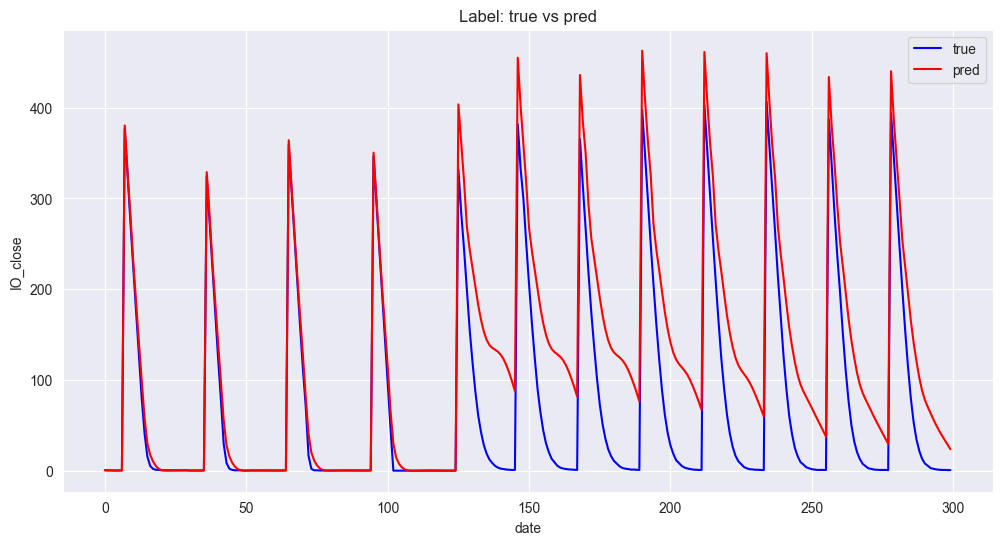

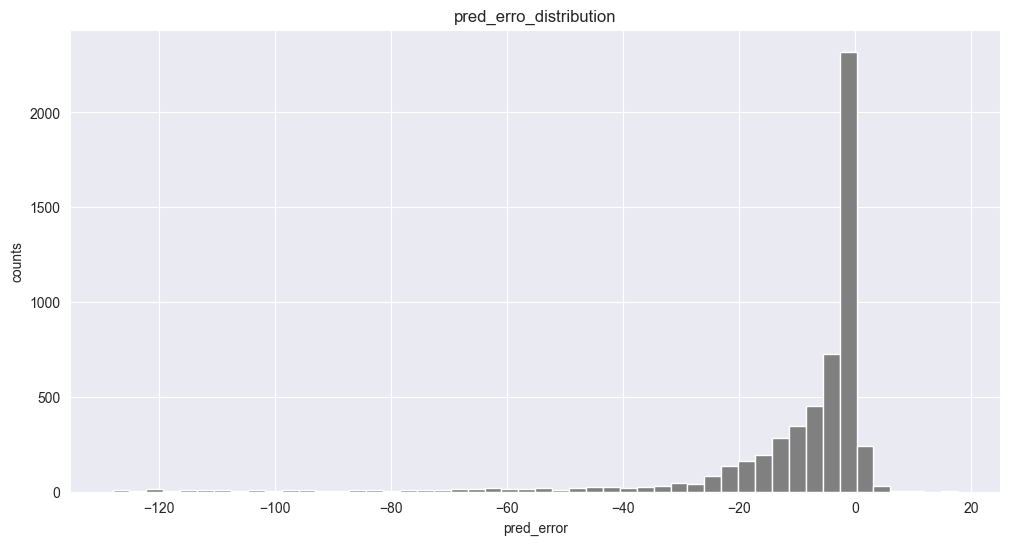


展示部分test_set上的拟合效果
        y_test  y_test_pred
0     1.200000     1.296490
1     1.000000     0.965458
2  1007.599976  1008.172485
3   907.799988   909.201355
4   808.000000   811.098389


测试集平均损失: 417.3516




In [25]:
# 模型评估
def LSTM_TEST(test_loader,args,model):
    model.to(args.device)
    criterion=args.criterion
    model.eval()  
    total_loss = 0.0
    
    with torch.no_grad():  # 在评估阶段不计算梯度
        for inputs, targets in test_loader:
            # 将数据移动到GPU上
            inputs,targets = inputs.to(args.device),targets.to(args.device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            total_loss += loss.item()
            
    #绘图和计算误差
    model.eval()  
    predictions = []
    actuals = []
    for inputs, targets in test_loader:
        inputs,targets = inputs.to(args.device),targets.to(args.device)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(targets.tolist())
        
    # 转换为numpy数组以便绘图
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # 可视化1: 真实值与预测值的对比
    plt.figure(figsize=(12, 6))
    plt.plot(actuals[-300:], label='true', color='blue')
    plt.plot(predictions[-300:], label='pred', color='red')
    plt.title('Label: true vs pred')
    plt.xlabel('date')
    plt.ylabel('IO_close')
    plt.legend()
    plt.show()
    
    # 可视化2: 预测误差的分布
    errors = actuals - predictions
    plt.figure(figsize=(12, 6))
    plt.hist(errors, bins=50, color='gray')
    plt.title('pred_erro_distribution')
    plt.xlabel('pred_error')
    plt.ylabel('counts')
    plt.show()
    
    # 将测试集的实际值和预测值转换为numpy数组（如果它们还不是的话）
    actuals_np = np.array(actuals)  
    predictions_np = np.array(predictions)  
    results_df = pd.DataFrame({'y_test': actuals_np,'y_test_pred': predictions_np})
    # 显示DataFrame的前几行
    print("\n展示部分test_set上的拟合效果")
    print(results_df.head())
    print('\n')
    print(f'测试集平均损失: {total_loss/len(test_loader):.4f}\n')
    return results_df

test_loader=LoadData(data_IO_C_all)[2]
LSTM_TEST(test_loader,args,model)
print('\n')